In [484]:
import sprf
from sprf.spatial_random_forest import SpatialRandomForest
from sprf.geographical_random_forest import GeographicalRandomForest
import glob
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [7]:
!cd

C:\Users\Chad\Desktop\CRWA Project\CRWA-Regional-Tree-Planting-and-Protection-Plan\CRWA-Regional-Tree-Planting-and-Protection-Plan\Notebooks


# Get and clean data from harmonic regression

In [12]:
# Get file paths for all the harmonic regression results
harmreg_fps=glob.glob('../../../Working_Data/*harmreg*')
harmreg_fps

['../../../Working_Data\\B11harmreg.csv',
 '../../../Working_Data\\B12harmreg.csv',
 '../../../Working_Data\\B2harmreg.csv',
 '../../../Working_Data\\B3harmreg.csv',
 '../../../Working_Data\\B4harmreg.csv',
 '../../../Working_Data\\B5harmreg.csv',
 '../../../Working_Data\\B6harmreg.csv',
 '../../../Working_Data\\B7harmreg.csv',
 '../../../Working_Data\\B8Aharmreg.csv',
 '../../../Working_Data\\B8harmreg.csv',
 '../../../Working_Data\\NBRharmreg.csv',
 '../../../Working_Data\\NDVIharmreg.csv',
 '../../../Working_Data\\RENDVIharmreg.csv',
 '../../../Working_Data\\SAVIharmreg.csv']

In [16]:
#Read in all cleaned data
AllData=gpd.read_file('../../../Working_Data/2023BandsIndicesCleaned.shp',engine="pyogrio").dropna()

In [27]:
# DataFrame with PtID and their corresponding geometries
PointsIDCrossWalk=AllData[['PtID','geometry']].drop_duplicates().reset_index()

In [445]:
#Note that in creating the data in the HPC, somehow some [] got added so these were removed in notepad
#Looping through each chunk of harmonic regression results and using PtID crosswalk to recombine everything 
bandsInd=['B3','B4','B5','B6','B7','B8','B8A','B11','B12','NBR','NDVI','RENDVI','SAVI']
current=pd.read_csv('../../../Working_Data/B2harmreg.csv').iloc[:53064,:]

#When exporting data from HPC, PtID was incorrectly assigned so is fixed here
current['PtID']=current.index
current['RMSE']=current['RMSE'].to_list()

#Joining data for first dataset and then looping through the rest
joined_gdf=PointsIDCrossWalk.join(current, on='PtID',rsuffix='B2')
for band in bandsInd:
    current=pd.read_csv('../../../Working_Data/'+band+'harmreg.csv').iloc[:53064,:]
    current['RMSE']=current['RMSE'].to_list()
    current['PtID']=current.index
    joined_gdf=joined_gdf.join(current, on='PtID',rsuffix=band)

In [446]:
joined_gdf.drop(['index','Unnamed: 0','PtIDB2','PtIDB3','PtIDB4','PtIDB5','PtIDB6','PtIDB7','PtIDB8','PtIDB8A','PtIDB11','PtIDB12','PtIDNBR','PtIDNDVI','PtIDRENDVI','PtIDSAVI'], axis=1, inplace=True)

In [447]:
joined_gdf.columns

Index(['PtID', 'geometry', 'RMSE', 'a', 'b', 'c', 'd', 'e', 'f', 'g',
       ...
       'RMSESAVI', 'aSAVI', 'bSAVI', 'cSAVI', 'dSAVI', 'eSAVI', 'fSAVI',
       'gSAVI', 'hSAVI', 'iSAVI'],
      dtype='object', length=155)

In [448]:
joined_gdf

,PtID,geometry,RMSE,a,b,c,d,e,f,g,...,RMSESAVI,aSAVI,bSAVI,cSAVI,dSAVI,eSAVI,fSAVI,gSAVI,hSAVI,iSAVI
0,0,POINT (-71.18363 42.27880),0.108714,0.082168,0.018238,0.002908,0.008055,0.011457,-0.031858,0.040369,...,0.093187,0.308574,-0.177817,-0.052801,0.025765,-0.005500,0.025471,0.004845,-0.049908,-0.019157
1,1,POINT (-71.18354 42.27889),0.109872,0.082926,0.016195,0.003335,0.005731,0.012650,-0.034720,0.039413,...,0.082235,0.274358,-0.194771,-0.020712,0.027089,0.003627,0.028306,0.017664,-0.034463,-0.013317
2,2,POINT (-71.18354 42.27880),0.109715,0.082934,0.019384,0.003114,0.007526,0.013223,-0.032818,0.041757,...,0.093993,0.310439,-0.197714,-0.046636,0.025042,-0.003893,0.027430,0.017192,-0.045066,-0.017068
3,3,POINT (-71.18363 42.27871),0.108432,0.084420,0.023075,0.004499,0.009740,0.013271,-0.029711,0.041747,...,0.096920,0.309838,-0.170040,-0.063541,0.030032,-0.009159,0.024926,0.006730,-0.046710,-0.023122
4,4,POINT (-71.18354 42.27871),0.109394,0.084496,0.022739,0.004970,0.010524,0.014203,-0.031255,0.043595,...,0.096329,0.314740,-0.179227,-0.054586,0.029666,-0.010468,0.024998,0.012149,-0.047793,-0.019820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52617,53058,POINT (-71.12299 42.26838),0.130107,0.086000,-0.012173,0.011096,0.024114,0.040270,-0.016385,0.019722,...,0.115792,0.359297,-0.209285,-0.063625,0.011961,-0.023933,0.004018,0.031710,-0.064396,-0.013665
52618,53060,POINT (-71.12281 42.26767),0.132368,0.081331,-0.023482,0.009601,0.029991,0.031841,-0.023295,0.013198,...,0.106719,0.311730,-0.186851,-0.084163,-0.012175,-0.020367,0.025501,0.035422,-0.061444,-0.004071
52619,53061,POINT (-71.12272 42.26767),0.132051,0.083370,-0.020887,0.010890,0.028380,0.034054,-0.020636,0.012929,...,0.107044,0.313599,-0.177302,-0.079380,-0.017087,-0.019076,0.021610,0.031283,-0.064237,-0.006490
52620,53062,POINT (-71.12263 42.26767),0.132178,0.083179,-0.018949,0.010371,0.027976,0.034181,-0.018406,0.012766,...,0.102038,0.301431,-0.160054,-0.080544,-0.014149,-0.011086,0.019898,0.029993,-0.054372,-0.011169


# Split into test, train, and validation datasets

# Need to find some native understory species to use as comparison

In [449]:
#Boston boundary
towns=gpd.read_file('../../../Raw_Data/CENSUS2020TOWNS_SHP/CENSUS2020TOWNS_POLY.shp').to_crs(epsg=3857).dissolve('NAMELSAD20')
Boston_gdf=towns[towns.index=='Boston city']

In [450]:
#Deciduous Forests
forestpolygons=gpd.read_file('../../../Working_Data/dforestBoston.shp').to_crs(epsg=3857)

In [451]:
# Multiflora rose, bittersweet, glossy buckthorn
bittersweet=gpd.read_file('../../../Working_Data/Invasives/Bittersweet.shp',engine="pyogrio").clip(forestpolygons)
multiflora=gpd.read_file('../../../Working_Data/Invasives/Multiflora.shp',engine="pyogrio").clip(forestpolygons)
buckthorn=gpd.read_file('../../../Working_Data/Invasives/Buckthorn.shp',engine="pyogrio").clip(forestpolygons)

In [468]:
bittersweet['species']=0
multiflora['species']=1
buckthorn['species']=2

#12 training pixels for bitterswet
#7 for multiflora rose
#12 for buckthorn

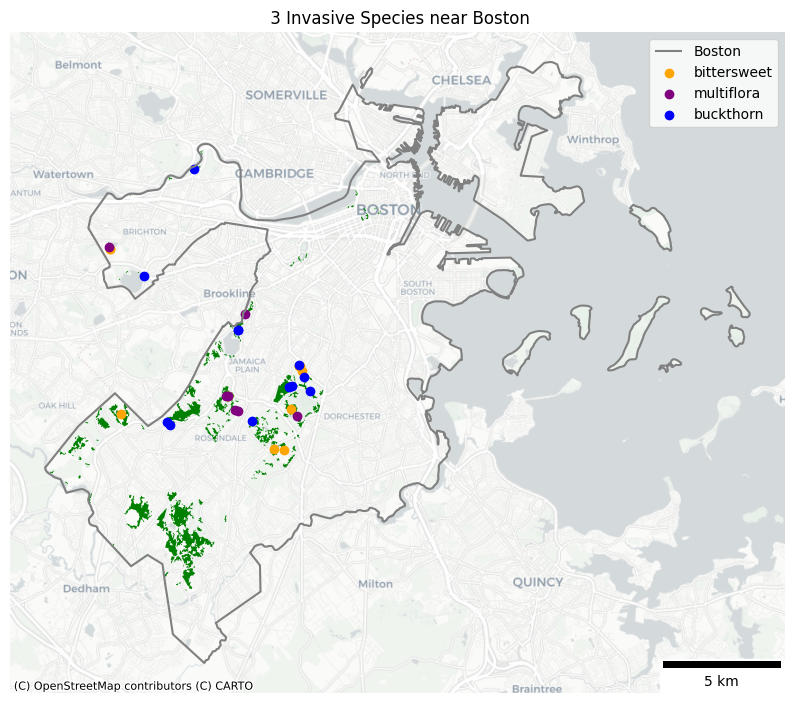

In [469]:
ax=Boston_gdf.boundary.plot(color='gray',figsize=(10,10))
forestpolygons.plot(color='green',ax=ax)
bittersweet.plot(color='orange',ax=ax)
multiflora.plot(color='purple',ax=ax)
buckthorn.plot(color='blue',ax=ax)
plt.title(" 3 Invasive Species near Boston")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.legend(labels=['Boston','bittersweet','multiflora','buckthorn'])
ax.add_artist(ScaleBar(1,location='lower right'))
plt.show()

In [470]:
#Append all invasives into one training set
mixedinvasives=pd.concat([buckthorn,multiflora,bittersweet])
mixedinvasives=mixedinvasives[['geometry','species']]

In [471]:
#Extract PtIDs of invasive sites
PtIDs=PointsIDCrossWalk.to_crs(epsg=3857)
sites_idx=PtIDs.sjoin_nearest(mixedinvasives,max_distance=10)['PtID']
sites=PtIDs[np.isin(PtIDs['PtID'],sites_idx)]

In [472]:
sites

,index,PtID,geometry
27027,1810808,27343,POINT (-7919675.000 5205268.087)
27028,1810875,27344,POINT (-7919685.000 5205268.087)
27166,1820121,27482,POINT (-7919825.000 5205389.760)
27169,1820322,27485,POINT (-7919825.000 5205403.279)
27171,1820456,27487,POINT (-7919815.000 5205389.760)
...,...,...,...
47686,3198913,48093,POINT (-7916195.000 5205403.279)
47688,3199047,48095,POINT (-7916205.000 5205403.279)
51109,3428254,51540,POINT (-7915305.000 5204227.167)
51114,3428589,51545,POINT (-7915295.000 5204227.167)


In [473]:
PtIDs.sjoin_nearest(mixedinvasives,max_distance=10)[['PtID','species']]

,PtID,species
27027,27343,2
27028,27344,2
27166,27482,2
27169,27485,2
27171,27487,2
...,...,...
47686,48093,2
47688,48095,2
51109,51540,0
51114,51545,0


In [474]:
#Reproject joined data and add species info
joined_gdf_proj=joined_gdf.to_crs(epsg=4326)
joined_gdf_proj=pd.concat([joined_gdf_proj,PtIDs.sjoin_nearest(mixedinvasives,max_distance=10)[['species']]],axis=1)

In [475]:
# Determine total number of examples, and number of examples in train and test sets
frac_test=0.3
rng = np.random.default_rng(seed=121)
L=sites.shape[0]
M=int(L*(1-frac_test))
N=int(L*frac_test)

In [476]:
# Randomly select the indices for the needed number of examples from the set for train
train_indices=rng.choice(np.arange(0,L), size = M, replace = False, p = None)

# The test indices are the other rows that were not selected
test_indices=np.arange(0,L)[~np.isin(np.arange(0,L),train_indices)]

# Use indices to generate final arrays
x_train_idx=sites['PtID'].iloc[train_indices]
x_test_idx=sites['PtID'].iloc[test_indices]

In [477]:
train=joined_gdf_proj[np.isin(joined_gdf_proj['PtID'],x_train_idx)]
test=joined_gdf_proj[np.isin(joined_gdf_proj['PtID'],x_test_idx)]
validation=joined_gdf_proj[(~np.isin(joined_gdf_proj['PtID'],x_train_idx)) & (~np.isin(joined_gdf_proj['PtID'],x_test_idx))]

# Spatial RF

In [478]:
train['lon'] = train['geometry'].x
train['lat'] = train['geometry'].y
test['lon'] = test['geometry'].x
test['lat'] = test['geometry'].y
validation['lon'] = validation['geometry'].x
validation['lat'] = validation['geometry'].y

C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [479]:
train=train.drop(['PtID','geometry'],axis=1)
test=test.drop(['PtID','geometry'],axis=1)
validation=validation.drop(['PtID','geometry'],axis=1)

In [480]:
def prepare_data(data, target, lon="lon", lat="lat"):
    """Assumes that all other columns are used as covariates"""
    covariates = [col for col in data.columns if col not in [lon, lat, target]]
    return data[covariates], data[target], data[[lon, lat]]

In [492]:
train_x, train_y, train_coords = prepare_data(
    train,'species'
)
test_x, test_y, test_coords = prepare_data(
    test, 'species'
)
validation_x, validation_y, validation_coords = prepare_data(
    validation, 'species'
)

In [486]:
rf = RandomForestRegressor(max_depth=10)
rf.fit(train_x, train_y)
test_pred = rf.predict(test_x)

rmse_rf = root_mean_squared_error(test_pred, test_y)
print("Error of basic Random Forest: ", rmse_rf)

Error of basic Random Forest:  0.8611232974048104


In [494]:
rf.predict(validation_x)

array([1.61, 1.58, 1.61, ..., 1.13, 1.17, 1.26])

In [491]:
sp = SpatialRandomForest(
    max_depth=10, neighbors=10
)
sp.fit(train_x, train_y, train_coords)
test_pred = sp.predict(test_x, test_coords)

rmse_spatial_rf = root_mean_squared_error(test_pred, test_y)
print("Error of spatial Random Forest: ", rmse_spatial_rf)

ValueError: n_samples=46 should be >= n_clusters=100.